In [1]:
!pip install --user git+https://github.com/kilean20/pyTorchTemplate.git

  Cloning https://github.com/kilean20/pyTorchTemplate.git to /tmp/pip-req-build-m45utqac
  Running command git clone -q https://github.com/kilean20/pyTorchTemplate.git /tmp/pip-req-build-m45utqac
  Created wheel for pyTorchTemplate: filename=pyTorchTemplate-0.0.1-py3-none-any.whl size=6496 sha256=a81d244f89a0f5dc49ed00853c5e681bd2a824deecf467758a943ba0216fa149
  Stored in directory: /tmp/pip-ephem-wheel-cache-zklclxwp/wheels/15/b3/6d/10ca0e96789eddf8cbd29d87914215e75608e6930926678261
Successfully built pyTorchTemplate


In [2]:
import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy

In [3]:
import pyTorchTemplate as ptt
device = ptt.device

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [5]:
nsample = 16
nensemble = 16

# Targets

In [6]:
from scipy.special import airy

def func(x):
  return np.sin(np.pi*4*x)

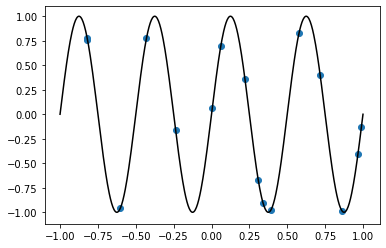

In [7]:
train_input = (np.random.rand(nsample)*2.0-1.0).reshape(-1,1).astype(np.float32)
train_output = func(train_input)

test_input = np.linspace(-1, 1, 512).reshape(-1,1).astype(np.float32)
test_output = func(test_input)

train_data_loader = torch.utils.data.DataLoader(list(zip(train_input,train_output)), batch_size=nsample, shuffle=False)
test_data_loader = torch.utils.data.DataLoader(list(zip(test_input,test_output)), batch_size=512, shuffle=False) 

for x,y in test_data_loader:
    plt.plot(x,y,c='k')
    
for x,y in train_data_loader:
    plt.scatter(x,y)        

# GP

In [8]:
kernel = C(0.2, (1e-3, 1e3)) * RBF(1, (1e-2, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [9]:
gp.score(train_input,train_output), gp.score(test_input,test_output)

(-0.0021684359435807377, -1.2522545222992676e-09)

In [10]:
gp.fit(train_input, train_output)
gp.kernel_

/usr/common/software/pytorch/v1.4.0/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


1.74**2 * RBF(length_scale=0.198)

In [11]:
gp.score(train_input,train_output), gp.score(test_input,test_output)

(0.9999999999999999, 0.9797541798956672)

# model collection

In [12]:
def test(model,test_data_loader):
    model.eval()
    loss = 0 
    for x, y in test_data_loader:
        x = x.to(device)
        y_pred = model(x)
        loss += torch.nn.MSELoss()(y_pred, y.to(device)).item()
    return loss/len(test_data_loader)

In [13]:
nModel = 16
nodes = [1,512,512,1]


model_outputs = [0]*nModel
model_test_outputs = [0]*nModel
Hist = [0]*nModel

for i in range(nModel):
    model = ptt.FCNN(nodes=nodes, activation=torch.nn.ReLU(inplace=True),dropout_p=0)
    old_best_loss = 10
    for j in range(8):
        mode,hist = ptt.train_supervised(model, 1.0e-2,1000,
                                         train_data_loader,
                                         criterion=torch.nn.MSELoss(),
                                         old_best_loss = old_best_loss,
                                         dispHead = 0, dispTail = 0)

        newloss = test(model,test_data_loader)
        print(j,newloss)

        if newloss < old_best_loss:
            old_best_loss = newloss
            final_model = copy(model)
            final_hist  = copy(hist)

        if newloss < 2e-3:
            break

    model = final_model
    hist = final_hist
    mode,hist = ptt.train_supervised(model,2.0e-4,2000,
                                     train_data_loader,
                                     old_hist = hist,
                                     criterion=torch.nn.MSELoss(),
                                     old_best_loss = newloss,
                                     dispHead = 0, dispTail = 0)
    Hist[i]=hist
    model_outputs[i] = []
    model_test_outputs[i] = []

    model.eval()  
    with torch.no_grad():
        for x,y in train_data_loader:
            surrogate_y = model(x.to(device))
            model_outputs[i] = model_outputs[i] + surrogate_y.cpu().tolist()

        for x,y in test_data_loader:  
            surrogate_y = model(x.to(device))
            model_test_outputs[i] = model_test_outputs[i] + surrogate_y.tolist()

0 0.307483434677124rain loss = 0.052274
1 0.2966412305831909ain loss = 0.043250
2 0.2907158136367798ain loss = 0.042993
3 0.2903136610984802ain loss = 0.042992
4 0.17043966054916382in loss = 0.000000
5 0.16714265942573547in loss = 0.000000
6 0.16685748100280762in loss = 0.000001
7 0.1668587625026703ain loss = 0.000000
0 0.15529413521289825in loss = 0.0017650
1 0.15772607922554016in loss = 0.027550
2 0.1469661444425583ain loss = 0.001569
3 0.1505093276500702ain loss = 0.000029
4 0.15693190693855286in loss = 0.000000
5 0.15680044889450073in loss = 0.000000
6 0.16519933938980103in loss = 0.000000
7 0.15912236273288727in loss = 0.000112
0 0.16118136048316956in loss = 0.0009640
1 0.1503174751996994ain loss = 0.000650
0 0.14639289677143097in loss = 0.0006140
1 0.13903869688510895in loss = 0.000059
2 0.1572318971157074ain loss = 0.000000
3 0.15485838055610657in loss = 0.000001
4 0.1589932143688202ain loss = 0.000000
5 0.1602417230606079ain loss = 0.003513
6 0.17582710087299347in loss = 0.0000

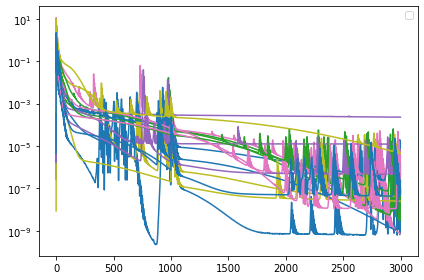

In [14]:
for hist in Hist:
  ptt.plot.history(hist)
plt.legend([])
plt.tight_layout()
plt.savefig('512_512_NNensemble_ReLU_hist.png',dpi=180)

In [15]:
model_test_outputs = np.array(model_test_outputs)
model_test_outputs_mean = np.mean(model_test_outputs,axis=0).reshape(-1,1)
model_test_outputs_std  = np.std(model_test_outputs,axis=0).reshape(-1,1)

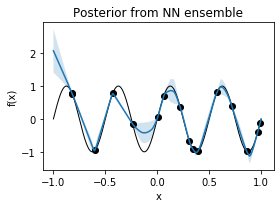

In [16]:
plt.figure(figsize=(4,3))

plt.plot(test_input,test_output,label='ground true',lw=1,c='k')
plt.fill_between(test_input[:,0], 
                 model_test_outputs_mean[:,0] + 1.96*model_test_outputs_std[:,0], 
                 model_test_outputs_mean[:,0] - 1.96*model_test_outputs_std[:,0], alpha=0.2, label='uncertainty')
plt.plot(test_input,model_test_outputs_mean,label='Mean')
plt.scatter(train_input,train_output,c='k',label='model on training')
plt.xlabel('x');
plt.ylabel('f(x)');
# plt.legend()
plt.title('Posterior from NN ensemble')
plt.tight_layout()
plt.savefig('512_512_NNensemble_ReLU.png',dpi=180)

In [17]:
gp_predict_mean, gp_predict_std = gp.predict(test_input, return_std=True)
gp_predict_mean = gp_predict_mean.reshape(-1)

/usr/common/software/pytorch/v1.4.0/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


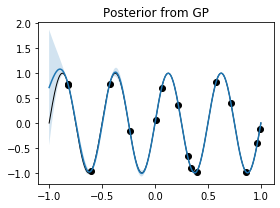

In [18]:
plt.figure(figsize=(4,3))

plt.plot(test_input,test_output,label='ground true',lw=1,c='k')
plt.fill_between(test_input[:,0], 
                 gp_predict_mean + 1.96*gp_predict_std, 
                 gp_predict_mean - 1.96*gp_predict_std, alpha=0.2, label='uncertainty')
plt.plot(test_input,gp_predict_mean,label='Mean')
plt.scatter(train_input,train_output,c='k',label='model on training')

# plt.legend()
plt.title('Posterior from GP')
plt.tight_layout()
plt.savefig('512_512_GP.png',dpi=180)

In [19]:
odel_outputs = [0]*nModel
model_test_outputs = [0]*nModel
Hist = [0]*nModel

for i in range(nModel):
    model = ptt.FCNN(nodes=nodes, activation=torch.nn.CELU(inplace=True),dropout_p=0)
    old_best_loss = 10
    for j in range(8):
        mode,hist = ptt.train_supervised(model, 1.0e-2, 1000,
                                         train_data_loader,
                                         criterion=torch.nn.MSELoss(),
                                         old_best_loss = old_best_loss,
                                         dispHead = 0, dispTail = 0)

        newloss = test(model,test_data_loader)
        print(j,newloss)

        if newloss < old_best_loss:
            old_best_loss = newloss
            final_model = copy(model)
            final_hist  = copy(hist)

        if newloss < 2e-3:
            break

    model = final_model
    hist = final_hist
    mode,hist = ptt.train_supervised(model,2.0e-4,2000,
                                     train_data_loader,
                                     old_hist = hist,
                                     criterion=torch.nn.MSELoss(),
                                     old_best_loss = newloss,
                                     dispHead = 0, dispTail = 0)
    Hist[i]=hist
    model_outputs[i] = []
    model_test_outputs[i] = []

    model.eval()  
    with torch.no_grad():
        for x,y in train_data_loader:
            surrogate_y = model(x.to(device))
            model_outputs[i] = model_outputs[i] + surrogate_y.cpu().tolist()

        for x,y in test_data_loader:  
            surrogate_y = model(x.to(device))
            model_test_outputs[i] = model_test_outputs[i] + surrogate_y.tolist()

0 0.36780524253845215in loss = 0.028721
1 0.26516056060791016in loss = 0.007765
2 0.2226262390613556ain loss = 0.004549
3 0.2995724081993103ain loss = 0.006738
4 0.20309194922447205in loss = 0.002609
5 0.18827031552791595in loss = 0.005740
6 0.2239351123571396ain loss = 0.001181
7 0.1954960823059082ain loss = 0.005845
0 0.3745403289794922ain loss = 0.0484909
1 0.30377838015556335in loss = 0.015804
2 0.1957852691411972ain loss = 0.006754
3 0.18085496127605438in loss = 0.005254
4 0.1909884512424469ain loss = 0.001773
5 0.16873206198215485in loss = 0.001341
6 0.177897647023201rain loss = 0.000655
7 0.2074591964483261ain loss = 0.000792
0 0.24131083488464355in loss = 0.0071292
1 0.2731817364692688ain loss = 0.004319
2 0.1875809282064438ain loss = 0.002833
3 0.1813317835330963ain loss = 0.111383
4 0.1590060144662857ain loss = 0.000711
5 0.1401444971561432ain loss = 0.000146
6 0.15535716712474823in loss = 0.000098
7 0.14449821412563324in loss = 0.000271
0 0.22207671403884888in loss = 0.01015

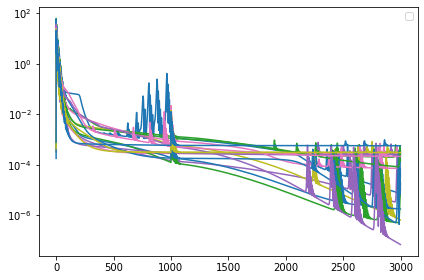

In [20]:
for hist in Hist:
  ptt.plot.history(hist)
plt.legend([])
plt.tight_layout()
plt.savefig('512_512_NNensemble_CELU_hist.png',dpi=180)

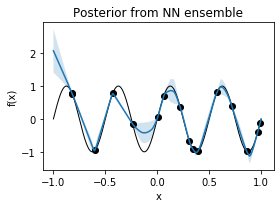

In [21]:
plt.figure(figsize=(4,3))

plt.plot(test_input,test_output,label='ground true',lw=1,c='k')
plt.fill_between(test_input[:,0], 
                 model_test_outputs_mean[:,0] + 1.96*model_test_outputs_std[:,0], 
                 model_test_outputs_mean[:,0] - 1.96*model_test_outputs_std[:,0], alpha=0.2, label='uncertainty')
plt.plot(test_input,model_test_outputs_mean,label='Mean')
plt.scatter(train_input,train_output,c='k',label='model on training')
plt.xlabel('x');
plt.ylabel('f(x)');
# plt.legend()
plt.title('Posterior from NN ensemble')
plt.tight_layout()
plt.savefig('512_512_NNensemble_CELU.png',dpi=180)